In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_palette('Set2')

%matplotlib inline

### Überblick über den Datensatz

Der analysierte Datensatz besteht aus bereinigten und feature-engineerten Transaktionsdaten und enthält sowohl numerische als auch kategoriale Merkmale. Die Struktur ist konsistent, vollständig und für eine weitere Modellierung geeignet.

Die Trennung zwischen Eingangsmerkmalen und Zielvariable (`FraudResult`) ist klar definiert, wodurch potenzielles Data Leakage vermieden wird. Insgesamt stellt der Datensatz eine stabile Grundlage für die nachfolgenden Analyse- und Modellierungsschritte dar.


In [2]:
Data_PATH = "../data/processed/training_preprocessed.csv"

df = pd.read_csv(Data_PATH)

df.head()

,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,FraudResult,ts_month,ts_is_weekend,ts_is_night,ts_hour_sin,ts_hour_cos,ts_dow_sin,ts_dow_cos,log_value,amount_value_ratio
0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2,0,11,0,1,0.500000,0.866025,0.433884,-0.900969,6.908755,0.999001
1,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2,0,11,0,1,0.500000,0.866025,0.433884,-0.900969,3.044522,0.952381
2,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2,0,11,0,1,0.500000,0.866025,0.433884,-0.900969,6.216606,0.998004
3,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2,0,11,0,1,0.707107,0.707107,0.433884,-0.900969,9.989711,0.917389
4,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2,0,11,0,1,0.707107,0.707107,0.433884,-0.900969,6.469250,0.998450


### Analyse der Zielvariable (FraudResult)

Die Zielvariable weist eine stark unausgeglichene Klassenverteilung auf, wobei betrügerische Transaktionen nur einen sehr kleinen Anteil des Datensatzes ausmachen. Dieses Verhalten ist typisch für reale Betrugserkennungsprobleme.

Der beobachtete Klassenimbalance macht deutlich, dass klassische Metriken wie Accuracy ungeeignet sind. Stattdessen werden im weiteren Verlauf spezialisierte Metriken sowie geeignete Trainingsstrategien erforderlich sein.


,Anzahl,Anteil (%)
FraudResult,,
0,95263,99.798
1,193,0.202


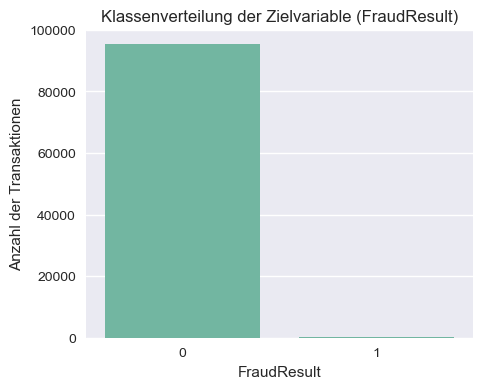

Baseline-Accuracy (immer Mehrheitsklasse): 99.80%


In [3]:
# Analyse der Zielvariable: FraudResult

TARGET = "FraudResult"

# Absolute Verteilung
counts = df[TARGET].value_counts().sort_index()

# Relative Verteilung
proportions = df[TARGET].value_counts(normalize=True).sort_index() * 100

summary = pd.DataFrame({
    "Anzahl": counts,
    "Anteil (%)": proportions.round(3)
})

display(summary)

# Visualisierung der Klassenverteilung
plt.figure(figsize=(5, 4))
sns.countplot(x=TARGET, data=df)
plt.title("Klassenverteilung der Zielvariable (FraudResult)")
plt.xlabel("FraudResult")
plt.ylabel("Anzahl der Transaktionen")
plt.show()

# Baseline Accuracy (Mehrheitsklasse)
baseline_acc = counts.max() / len(df) * 100
print(f"Baseline-Accuracy (immer Mehrheitsklasse): {baseline_acc:.2f}%")


### Univariate Analyse numerischer Merkmale

In diesem Abschnitt werden die numerischen Merkmale unabhängig von der Zielvariable analysiert. Ziel ist es, die Verteilungen der Features zu untersuchen sowie mögliche Ausreißer, Schiefe und Skaleneffekte zu identifizieren.

Insbesondere bei betragsbezogenen Variablen ist eine starke Rechtsschiefe zu erwarten, was die Notwendigkeit geeigneter Transformationen (z. B. Log-Transformation) für die spätere Modellierung unterstreicht.

Numerische Merkmale (12): ['Amount', 'Value', 'PricingStrategy', 'ts_month', 'ts_is_weekend', 'ts_is_night', 'ts_hour_sin', 'ts_hour_cos', 'ts_dow_sin', 'ts_dow_cos', 'log_value', 'amount_value_ratio']
Kategoriale Merkmale (4): ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId']



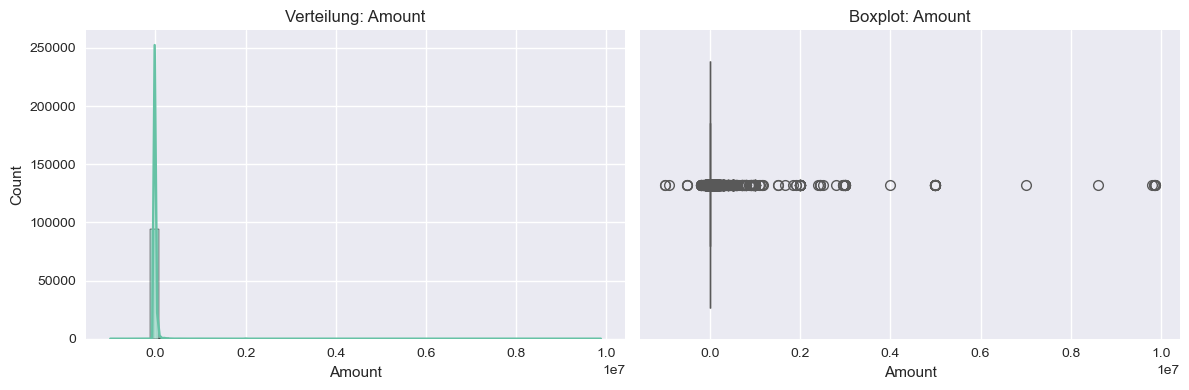

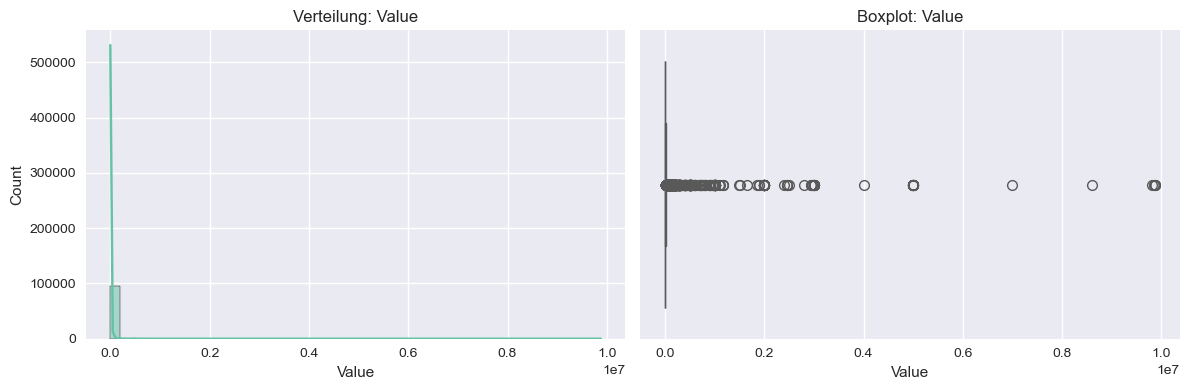

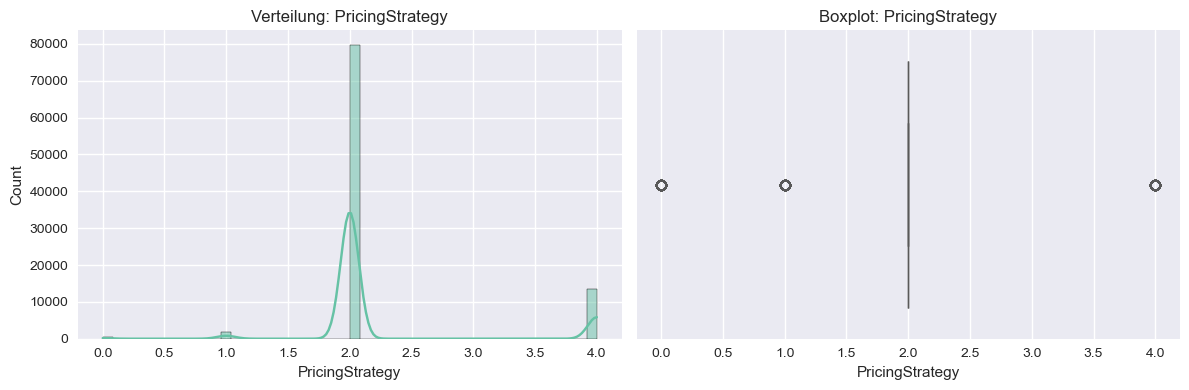

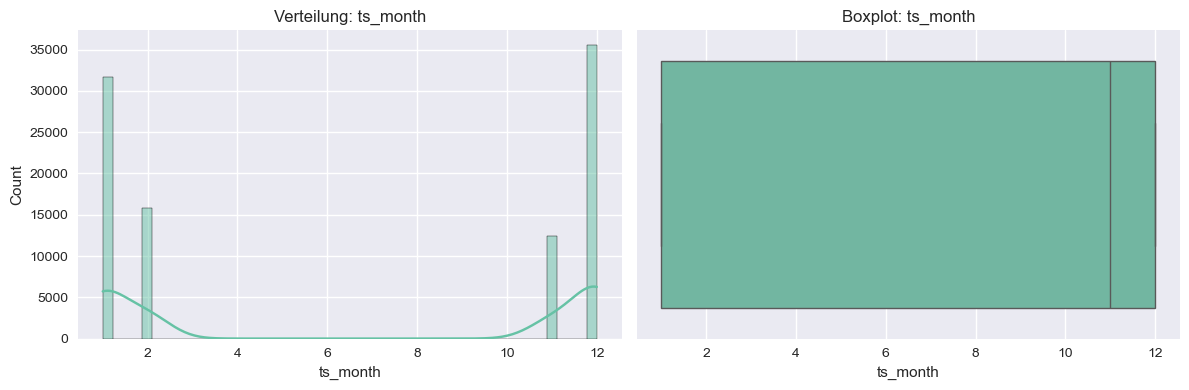

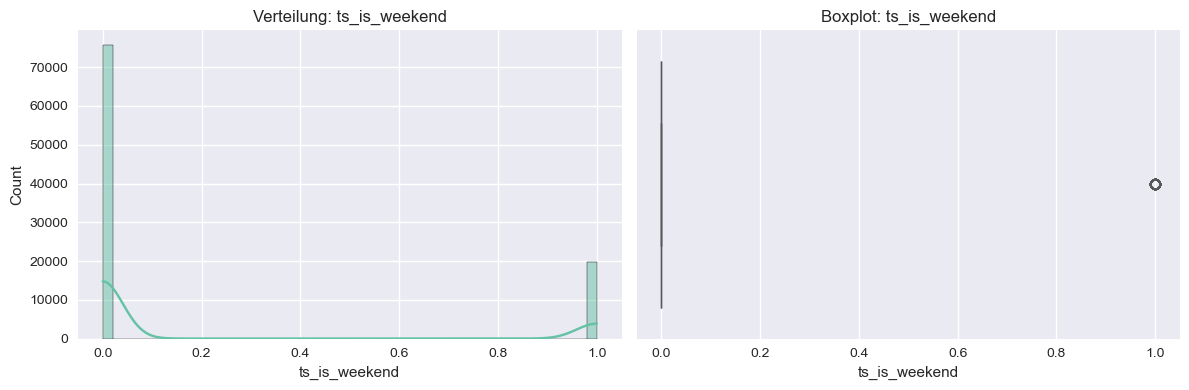

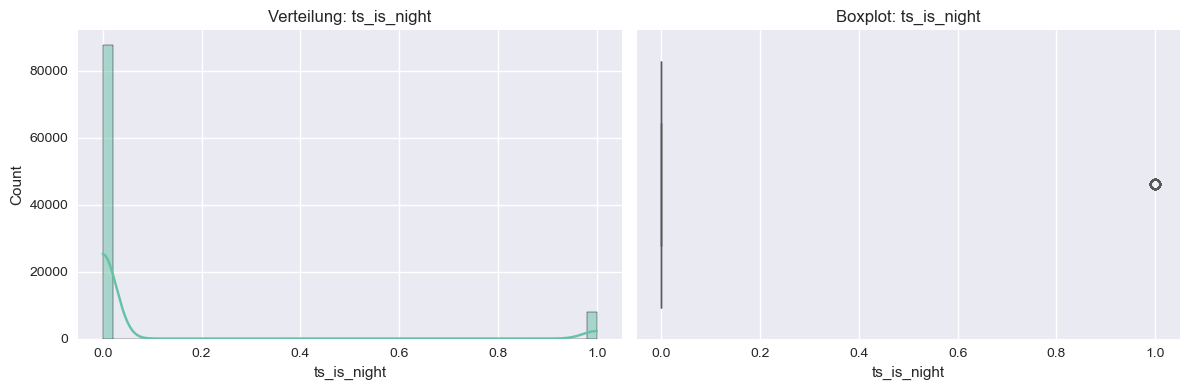

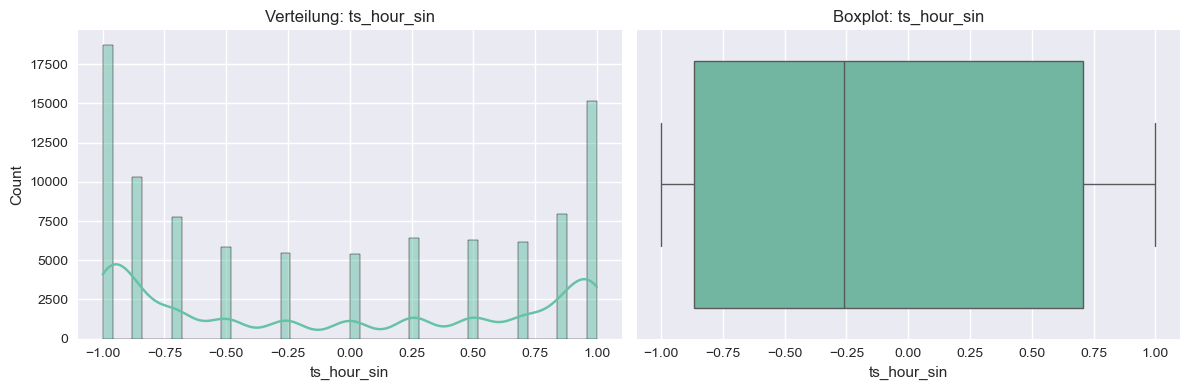

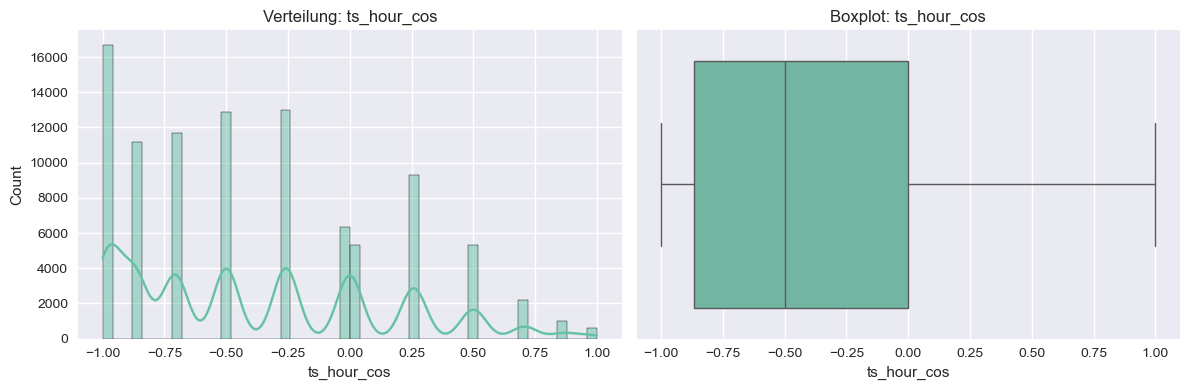

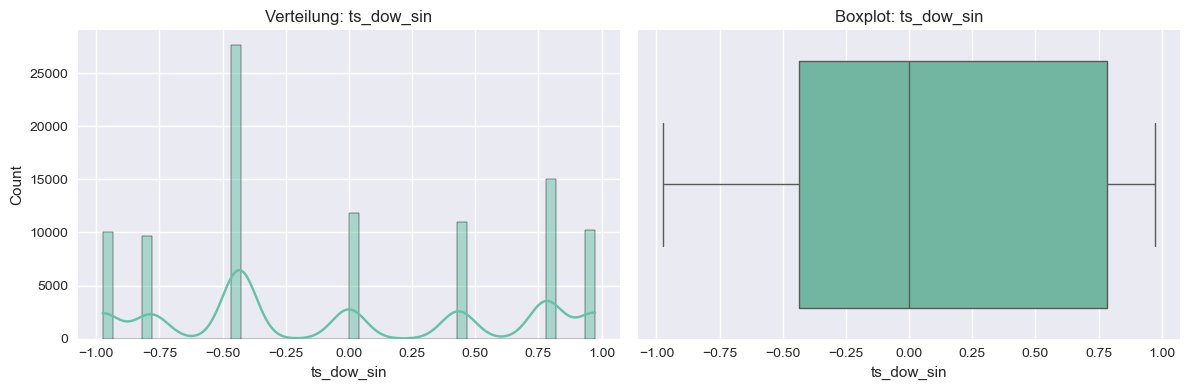

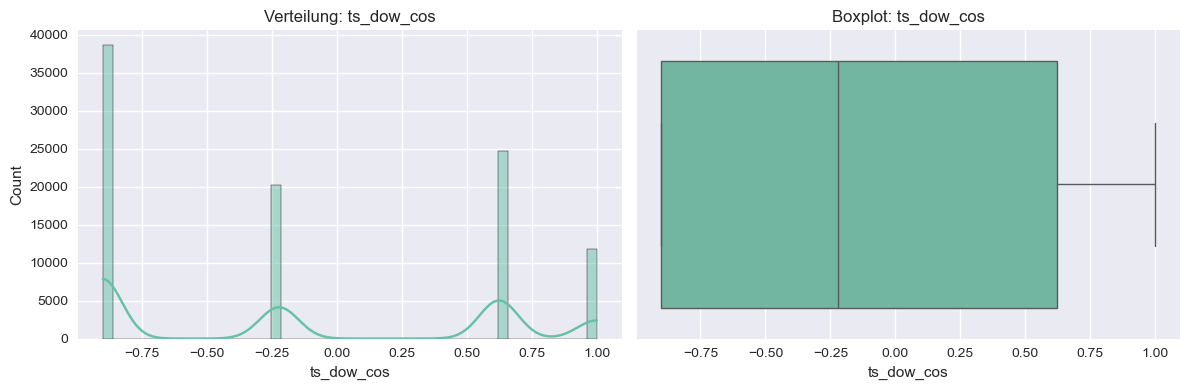

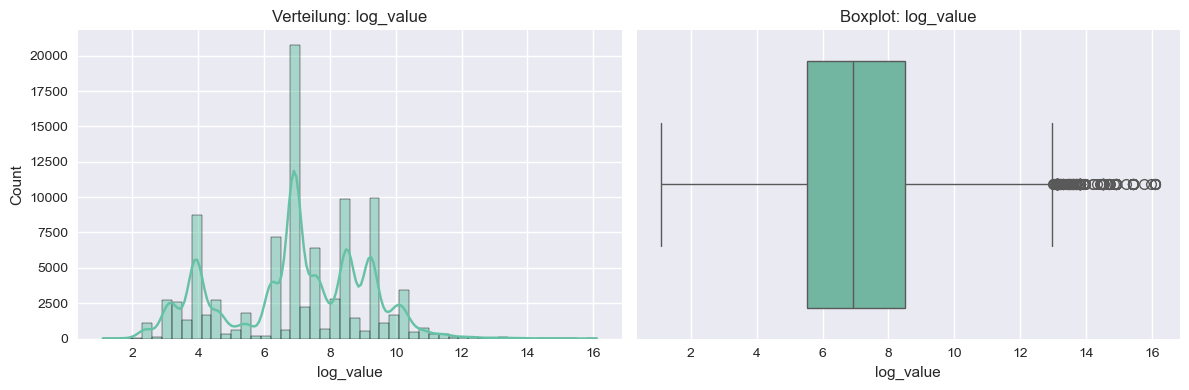

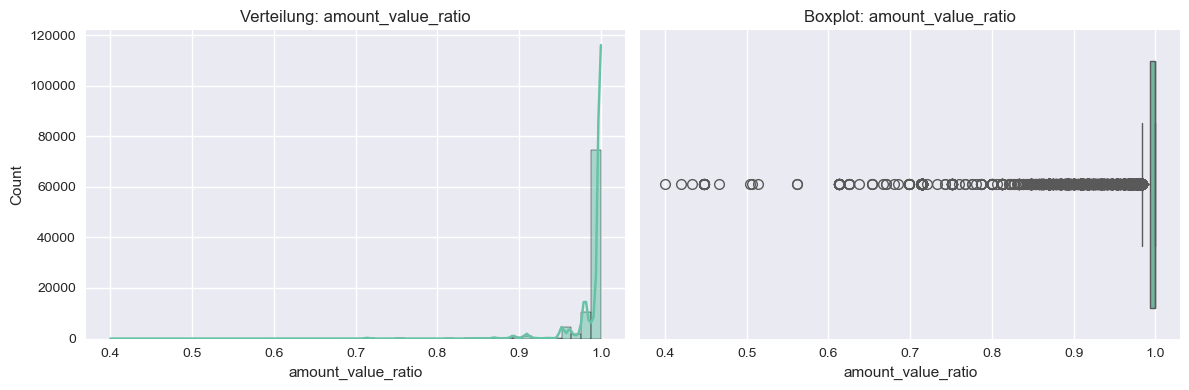

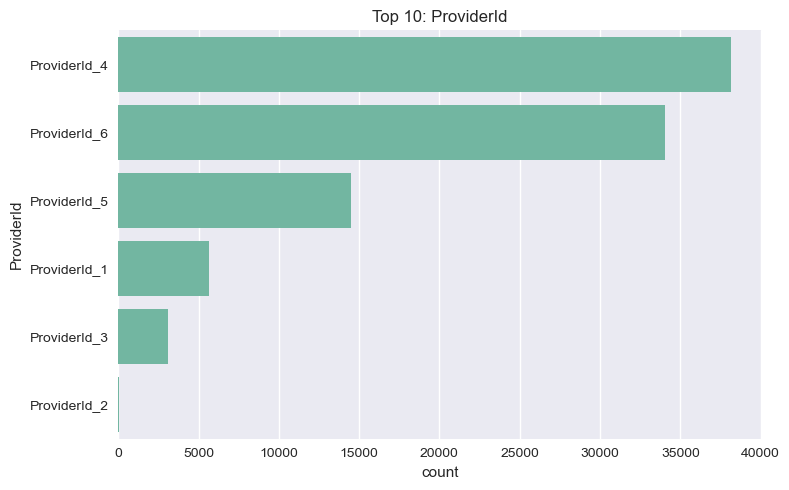

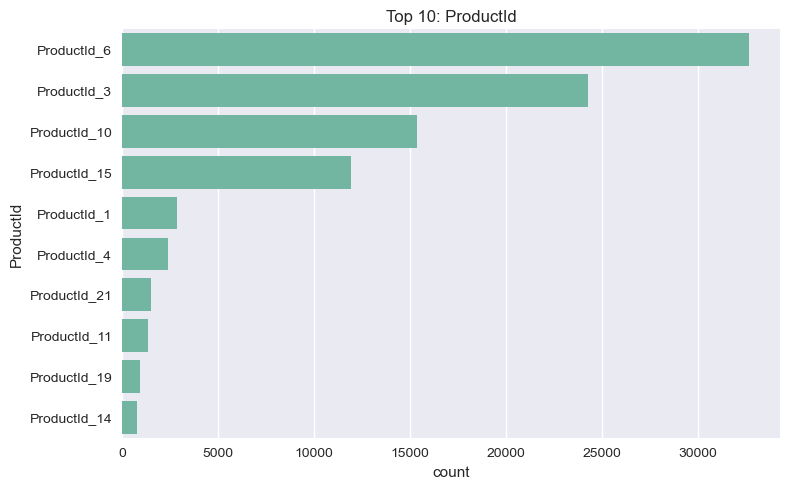

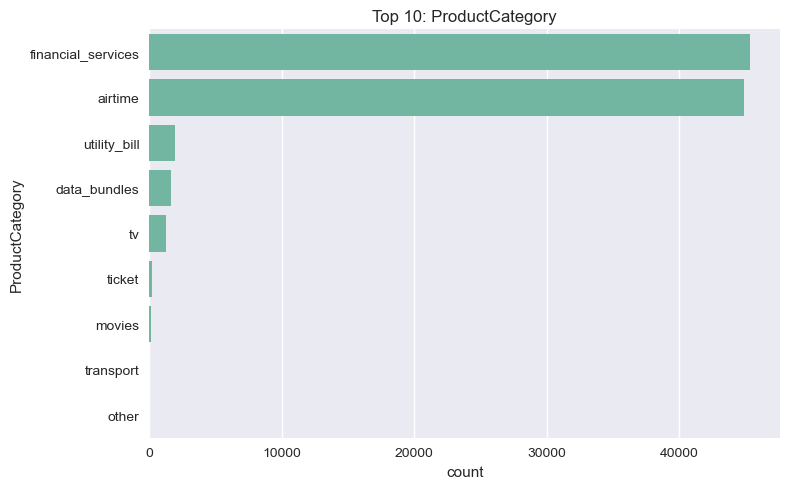

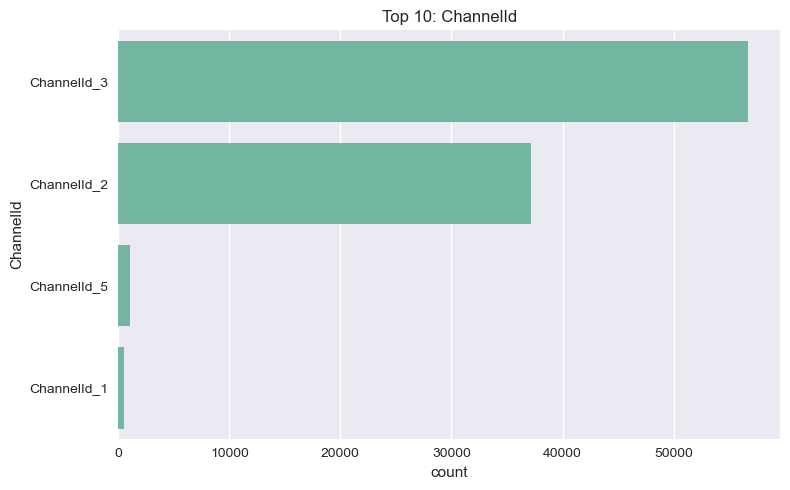

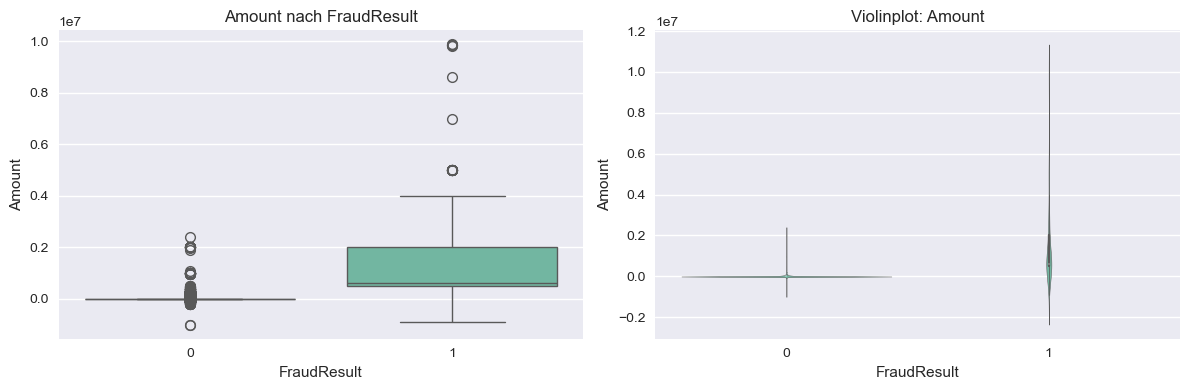

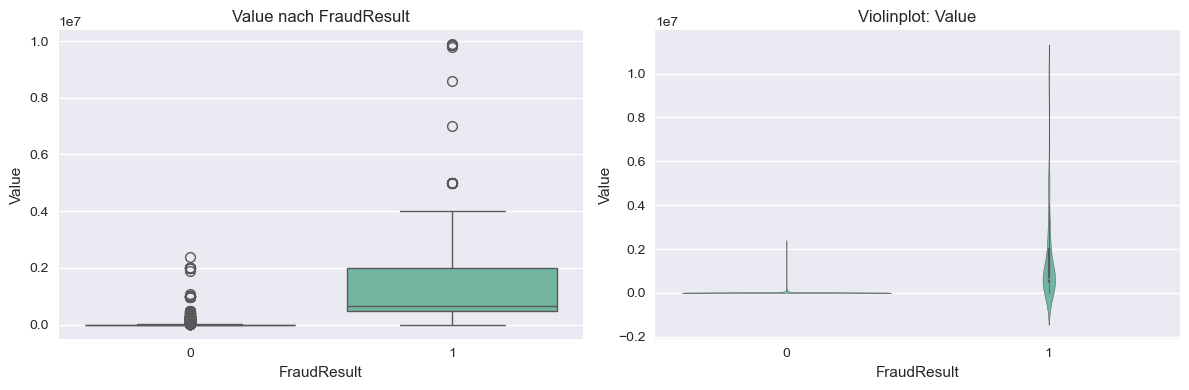

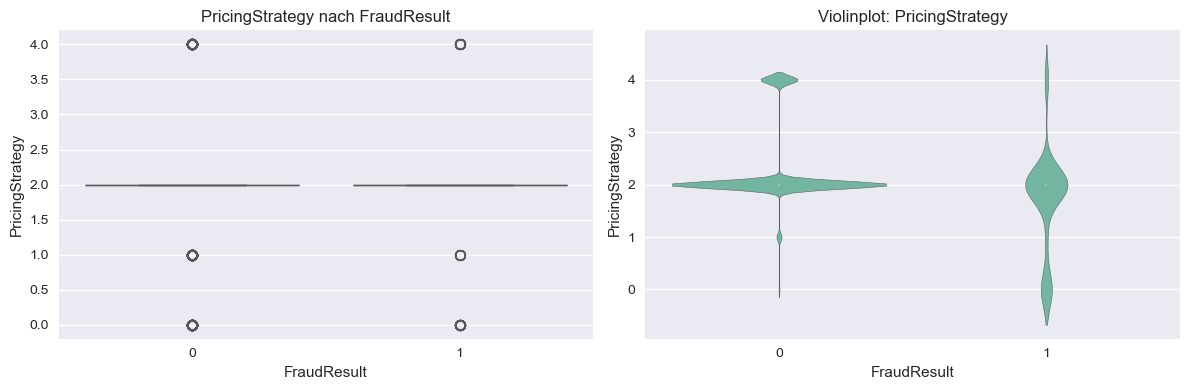

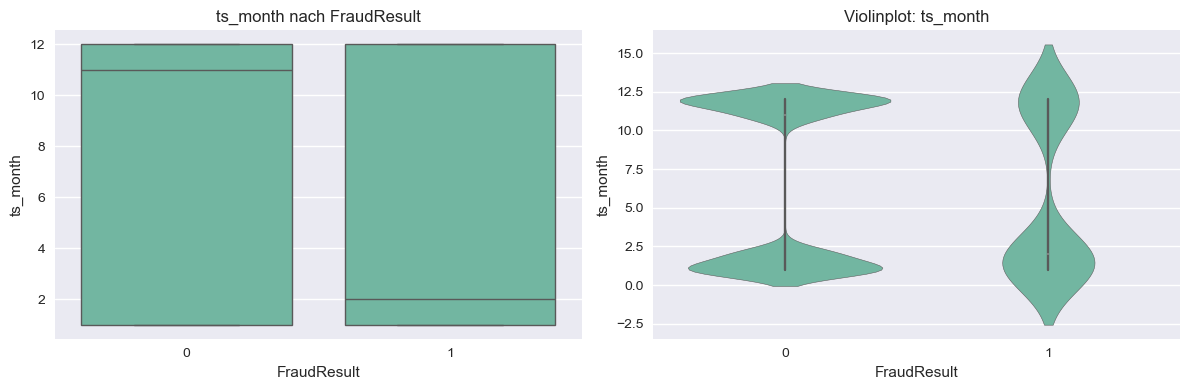

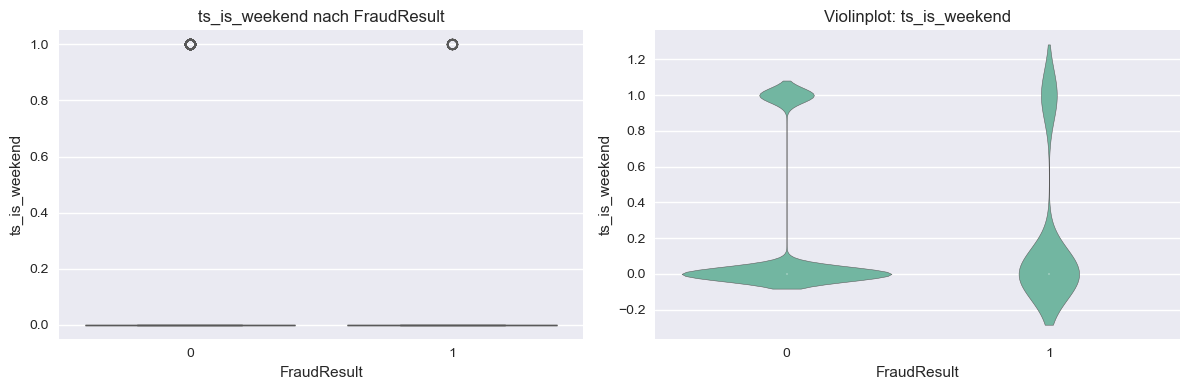

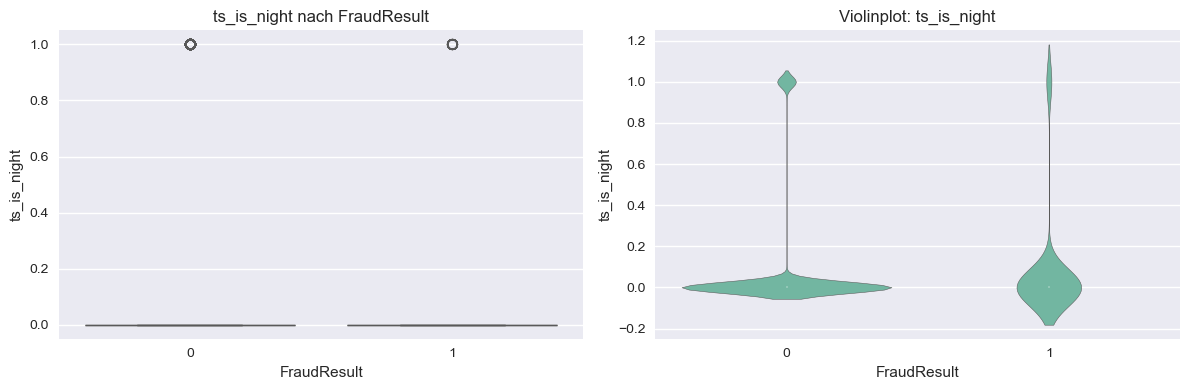

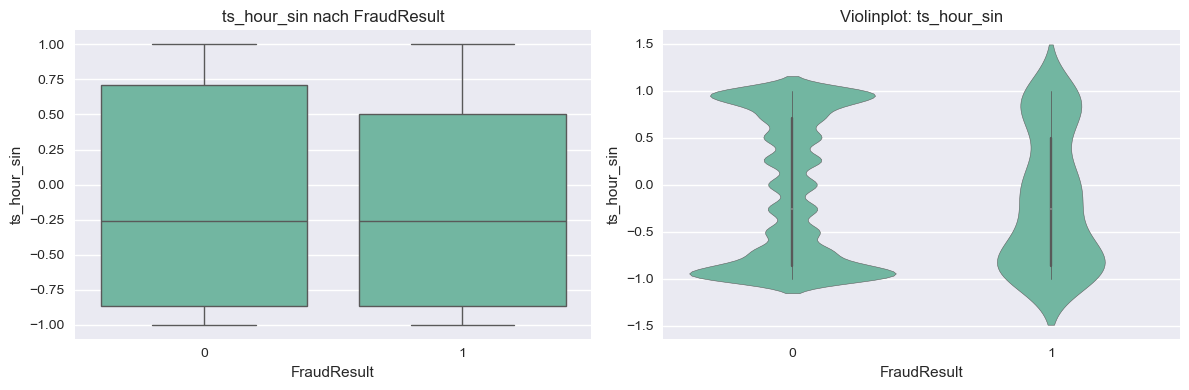

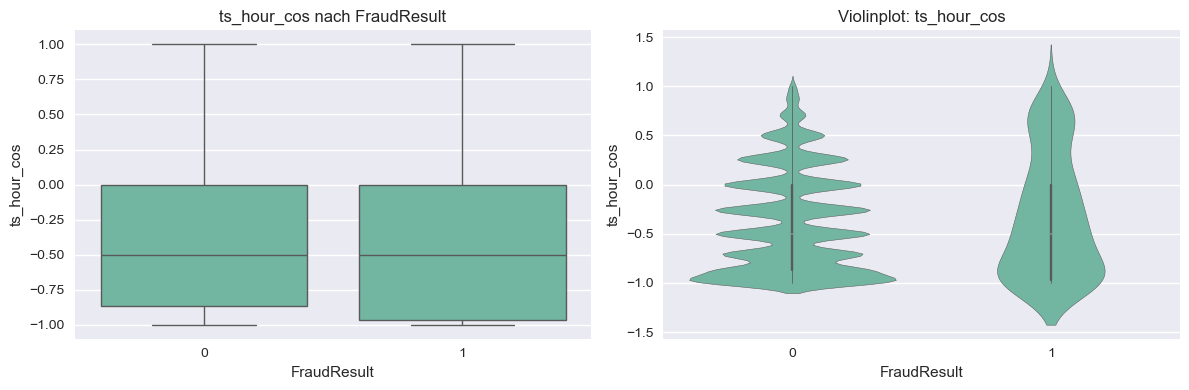

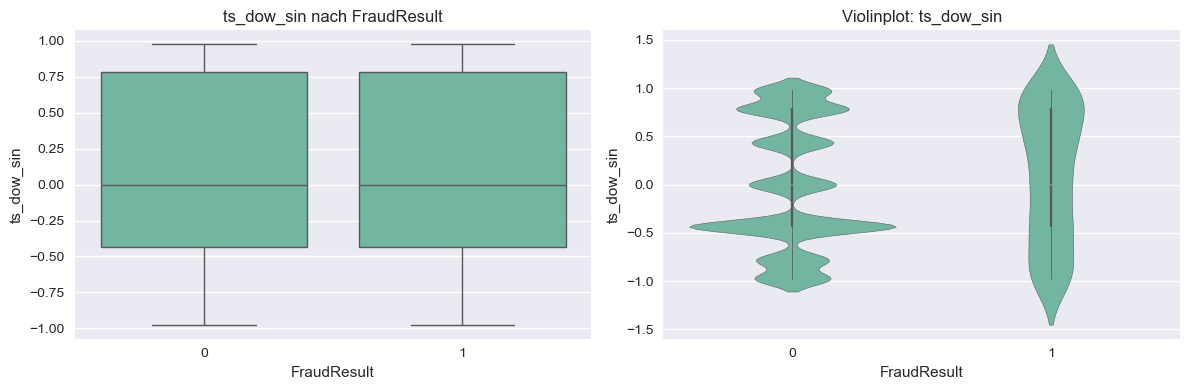

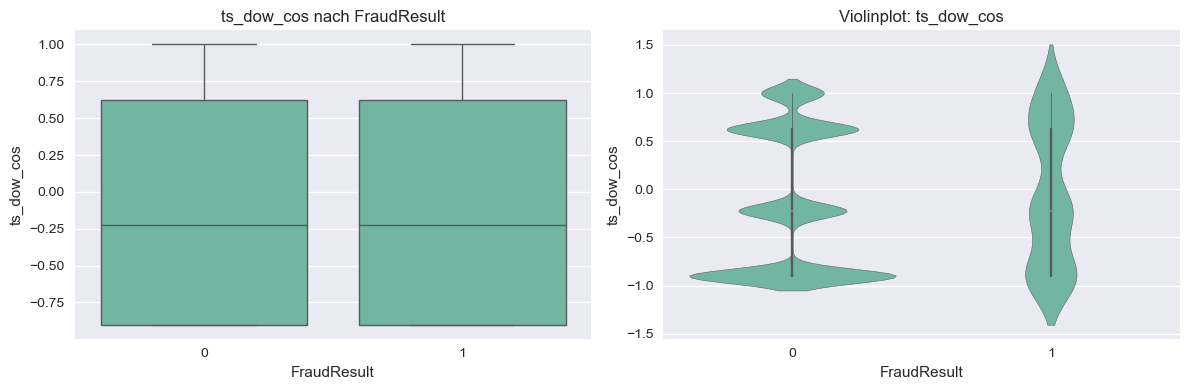

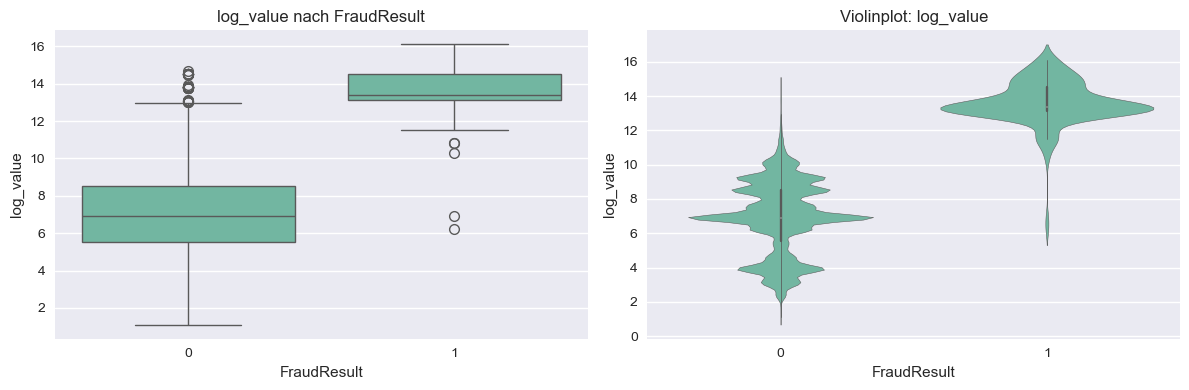

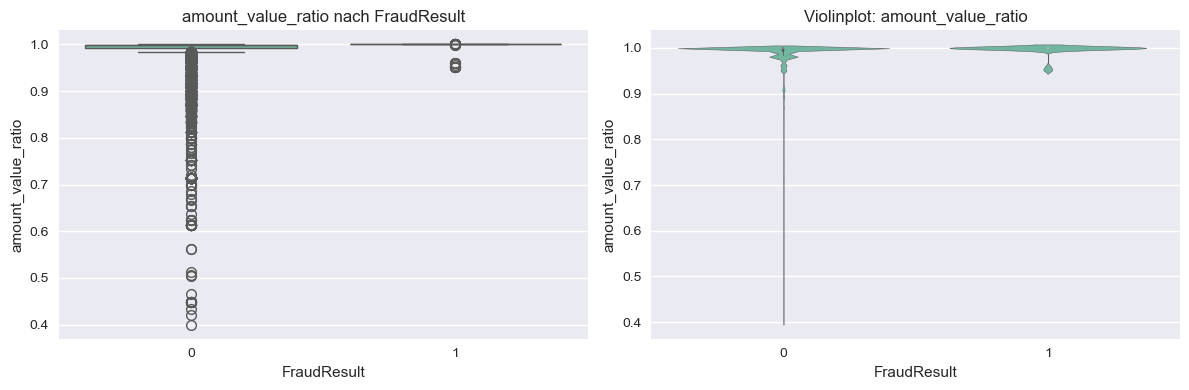

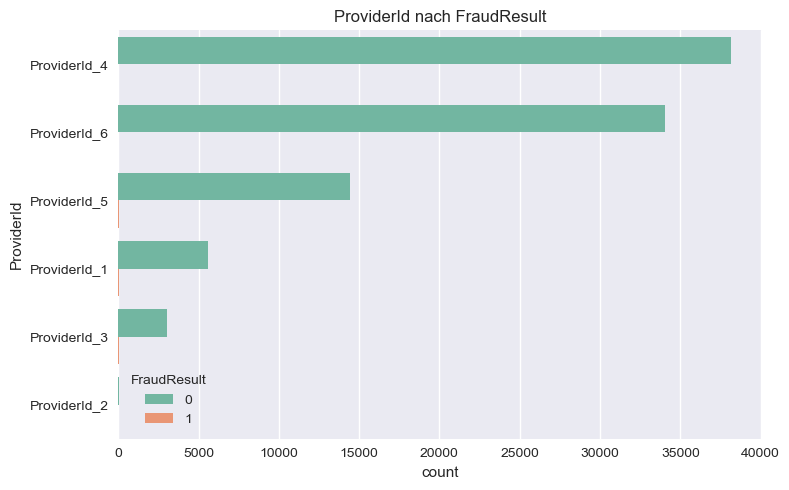

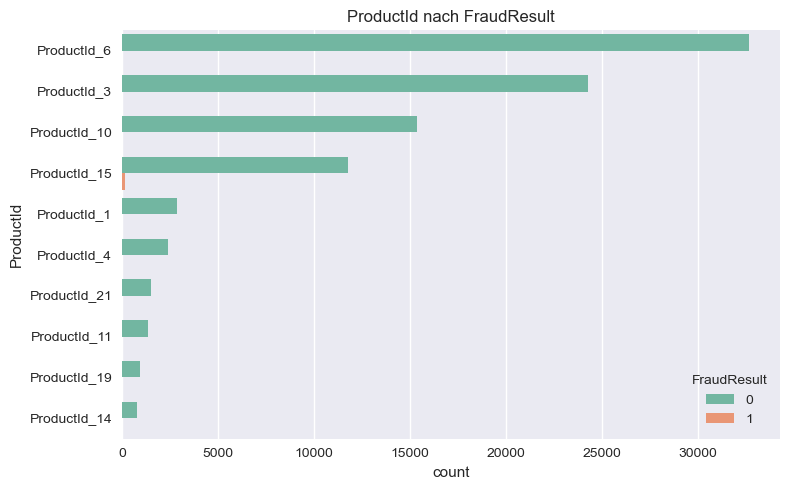

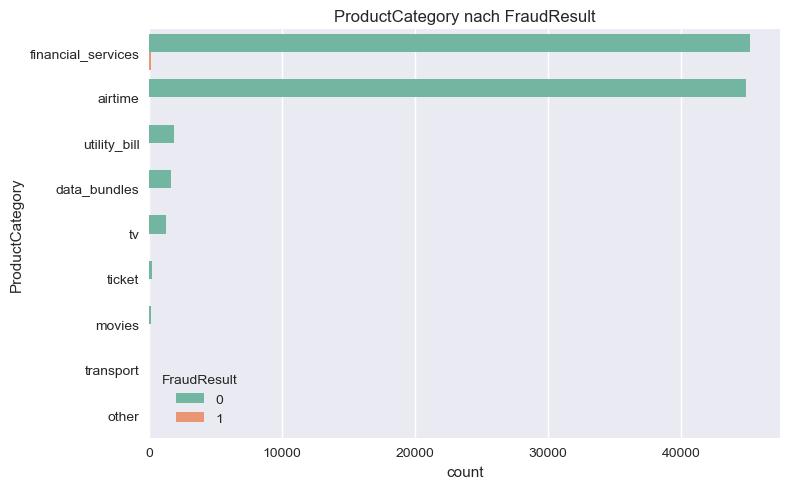

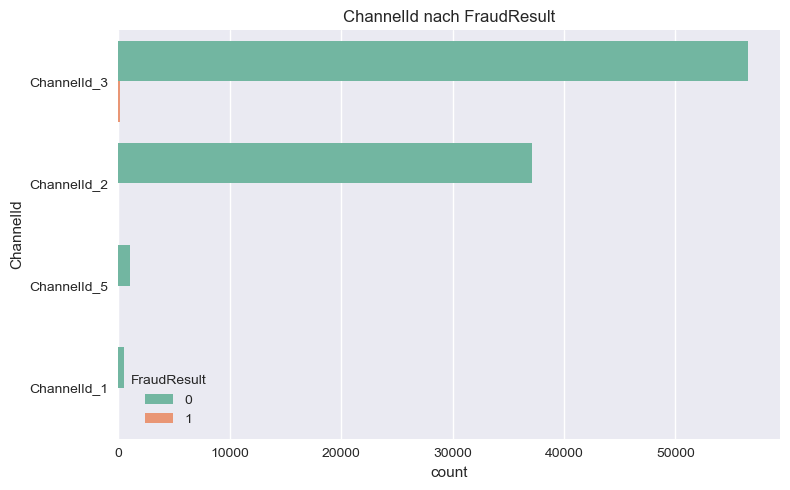

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_palette('Set2')
%matplotlib inline

# Extraktion der Merkmalslisten
TARGET = "FraudResult"
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove(TARGET)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerische Merkmale ({len(numeric_cols)}): {numeric_cols}")
print(f"Kategoriale Merkmale ({len(categorical_cols)}): {categorical_cols}\n")

# Univariate Analyse: numerische Merkmale
for col in numeric_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df[col], bins=50, kde=True, ax=ax[0])
    ax[0].set_title(f"Verteilung: {col}")
    sns.boxplot(x=df[col], ax=ax[1])
    ax[1].set_title(f"Boxplot: {col}")
    plt.tight_layout()
    plt.show()

# Univariate Analyse: kategoriale Merkmale
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(y=col, data=df, order=df[col].value_counts().head(10).index)
    plt.title(f"Top 10: {col}")
    plt.tight_layout()
    plt.show()

# Bivariate Analyse: numerische Merkmale vs. Zielvariable
for col in numeric_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.boxplot(x=TARGET, y=col, data=df, ax=ax[0])
    ax[0].set_title(f"{col} nach {TARGET}")
    sns.violinplot(x=TARGET, y=col, data=df, ax=ax[1])
    ax[1].set_title(f"Violinplot: {col}")
    plt.tight_layout()
    plt.show()

# Bivariate Analyse: kategoriale Merkmale vs. Zielvariable
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(y=col, hue=TARGET, data=df, order=df[col].value_counts().head(10).index)
    plt.title(f"{col} nach {TARGET}")
    plt.legend(title=TARGET)
    plt.tight_layout()
    plt.show()

### Korrelationsanalyse numerischer Merkmale

In diesem Abschnitt wird die Korrelation zwischen den numerischen Merkmalen sowie der Zielvariable (`FraudResult`) untersucht. Ziel ist es, **lineare Zusammenhänge**, **redundante Features** und potenzielle **Multikollinearität** zu identifizieren.

Die Korrelationsmatrix hilft dabei zu erkennen, welche Variablen stark miteinander zusammenhängen und welche Merkmale einen direkten linearen Zusammenhang mit der Zielvariable aufweisen. Diese Erkenntnisse sind besonders relevant für die Feature Selection sowie für Modelle, die empfindlich auf korrelierte Eingangsvariablen reagieren (z. B. **lineare Modelle**).


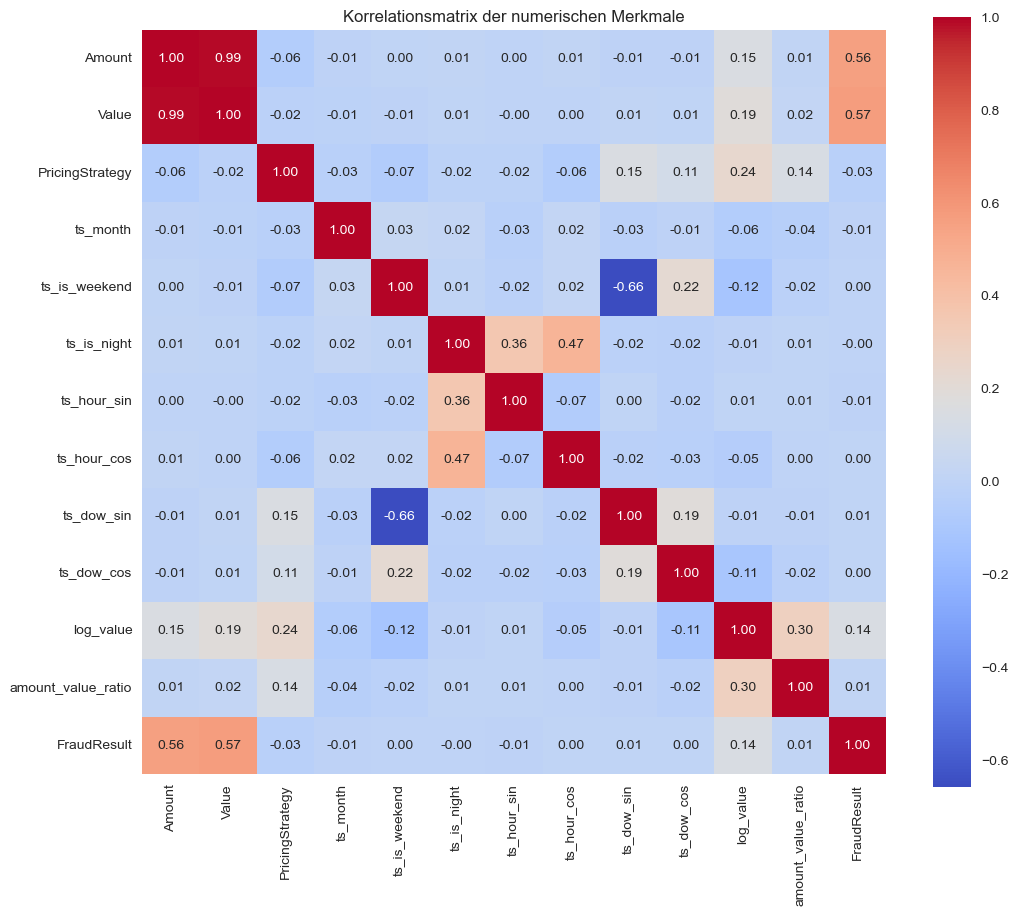

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns 

# korrelation matrix for numeric features
plt.figure(figsize=(12, 10))    
corr = df[numeric_cols + [TARGET]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Korrelationsmatrix der numerischen Merkmale")    
plt.show()



